In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#%matplotlib inline
import seaborn as sns
sns.set()
mpl.rcParams[u'font.sans-serif'] = ['SimHei']
mpl.rcParams['axes.unicode_minus'] = False

In [2]:
dataDir = "ML data"
df = pd.read_pickle("%s/tsData.pkl" % dataDir, compression="bz2")

In [3]:
citys = ['北京', '上海', '广州', '深圳', '成都', '重庆', '杭州', '西安']

In [289]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [4]:
def getData(city):
    return df[(df['车型new']=='A4L')&(df['城市']==city)][['月份', '城市汇总']].reset_index(drop=True).copy()

In [185]:
def procPeak(ser):
    tmpser = ser.copy()
    var = np.sqrt(np.var(tmpser))
    tmpadd = 3*var
    meanval = np.mean(tmpser)
    # 找到第一、第二极值，包括最大最小
    tmpmax = tmpser.sort_values(axis=0, ascending=False)[:2].reset_index()
    tmpmin = tmpser.sort_values(axis=0, ascending=True)[:3].reset_index()
    # print(tmpmin)
    tmax, tmin = tmpmax.loc[0].values, tmpmin.loc[1].values
    if tmpmax.iloc[0, 1]>(tmpmax.iloc[1, 1] + 2*var):
        # print(ser.loc[tmpmax.iloc[0, 0]])
        # print(tmpmax.iloc[1, 1], tmpadd)
        tmpser.loc[tmpmax.iloc[0, 0]] = meanval + tmpadd
        
    tmpser.loc[tmpmin.iloc[0, 0]] = np.mean([tmpmin.iloc[1, 1], tmpmin.iloc[2, 1]])
    # return tmpmax, tmpmin, var, tmpser, ser
    # return tmpser
    return [tmpmax.iloc[0, 0], int(meanval+tmpadd)], [tmpmin.iloc[0, 0], int(np.mean([tmpmin.iloc[1, 1], tmpmin.iloc[2, 1]]))]

In [172]:
procPeak(testdf['城市汇总'])

   index  城市汇总
0     25  3722
1      1  6538
2     24  8299


([20, 20285], [25, 7418])

In [191]:
def dGraph(rows, cols, df, proc=False):
    r, c  = 0, 0
    xlist = df.shape[0]
    #print(xlist)
    if not proc:
        title = "原始数据"
    else:
        title = "处理后"
    # plt.figure(figsize=(800, 100))
    figure, ax = plt.subplots(rows, cols, figsize=(40, 20),sharex="col")
    for colname in df:
        ax[r][c].plot(range(xlist), df[colname])
        ax[r][c].set_title(u"%s" % colname)
        if c < cols-1:
            c += 1
        else:
            c = 0
            r += 1
    figure.suptitle(title)
    plt.show()

In [181]:
def newdata(citys, manu=False):
    i = 0
    tmpdf = pd.DataFrame()
    for city in citys:
        # print(city)
        tmpdf[city] = getData(city)['城市汇总'].values
        if manu:
            mArr = procPeak(tmpdf[city])
            tmpdf.loc[mArr[0][0], city] = mArr[0][1]
            tmpdf.loc[mArr[1][0], city] = mArr[1][1]
    return tmpdf

In [359]:
class HoltWinters:
    """
    Holt-Winters model with the anomalies detection using Brutlag method
    
    # series - initial time series
    # slen - length of a season
    # alpha, beta, gamma - Holt-Winters model coefficients
    # n_preds - predictions horizon
    # scaling_factor - sets the width of the confidence interval by Brutlag (usually takes values from 2 to 3)
    
    """
    
    def __init__(self, series, slen, alpha, beta, gamma, n_preds, scaling_factor=1.96):
        self.series = series
        self.slen = slen
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma
        # print(alpha, beta, gamma)
        self.n_preds = n_preds
        self.scaling_factor = scaling_factor
    
    def init_trend(self):
        s = 0.0
        # print(len(self.series))
        for i in range(self.slen):
            # print(i, s)
            s += (self.series[i+self.slen] - self.series[i])/self.slen
        return s / self.slen
    
    def init_seasonal_components(self):
        seasonals = {}
        season_averages = []
        n_seasons = int(len(self.series)/self.slen)
        
        for j in range(n_seasons):
            season_averages.append(sum(self.series[self.slen*j: self.slen*(j+1)])/self.slen)
        
        for i in range(self.slen):
            sum_of_vals_over_avg = 0.0
            for j in range(n_seasons):
                sum_of_vals_over_avg += self.series[self.slen * j + i] - season_averages[j]
            seasonals[i] = sum_of_vals_over_avg/n_seasons
        return seasonals
    
    def triple_expotential_smoothing(self):
        self.result = []
        self.Smooth = []
        self.Season = []
        self.Trend = []
        self.PredictedDeviation = []
        self.UpperBond = []
        self.LowerBond = []
        
        seasonals = self.init_seasonal_components()
        
        for i in range(len(self.series) + self.n_preds):
            if i == 0:
                smooth = self.series[0]
                trend = self.init_trend()
                self.result.append(self.series[0])
                self.Smooth.append(smooth)
                self.Trend.append(trend)
                self.Season.append(seasonals[i % self.slen])
                self.PredictedDeviation.append(0)
                self.UpperBond.append(
                    self.result[0] +
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                self.LowerBond.append(
                    self.result[0] -
                    self.scaling_factor *
                    self.PredictedDeviation[0]
                )
                continue
            if i >= len(self.series):
                m = i - len(self.series) + 1
                self.result.append(smooth + m * trend + seasonals[i % self.slen])
                
                self.PredictedDeviation.append(
                    self.PredictedDeviation[-1] * 1.01
                )
            else:
                val = self.series[i]
                last_smooth, smooth = smooth, self.alpha * (val - seasonals[i % self.slen]) + (1 - self.alpha) * (smooth + trend)
                trend = self.beta * (smooth - last_smooth) + (1 - self.beta) * trend
                seasonals[i % self.slen] = self.gamma * (val - smooth) + (1 - self.gamma) * seasonals[i % self.slen]
                self.result.append(smooth + trend + seasonals[i % self.slen])
                
                self.PredictedDeviation.append(
                    self.gamma * np.abs(self.series[i] - self.result[i]) +
                    (1 - self.gamma) * self.PredictedDeviation[-1]
                )
            
            self.UpperBond.append(
                self.result[-1] +
                self.scaling_factor *
                self.PredictedDeviation[-1]
            )
            
            self.LowerBond.append(
                self.result[-1] -
                self.scaling_factor *
                self.PredictedDeviation[-1]
            )
            
            self.Smooth.append(smooth)
            self.Trend.append(trend)
            self.Season.append(seasonals[i % self.slen])

In [291]:
def plotHoltWinters(series, plot_intervals=False, plot_anomalies=False):
    """
        series - dataset with timeseries
        plot_intervals - show confidence intervals
        plot_anomalies - show anomalies 
    """
    
    plt.figure(figsize=(20, 10))
    plt.plot(model.result, label = "Model")
    plt.plot(series.values, label = "Actual")
    error = mean_absolute_percentage_error(series.values, model.result[:len(series)])
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    
    if plot_anomalies:
        anomalies = np.array([np.NaN]*len(series))
        anomalies[series.values<model.LowerBond[:len(series)]] = \
            series.values[series.values<model.LowerBond[:len(series)]]
        anomalies[series.values>model.UpperBond[:len(series)]] = \
            series.values[series.values>model.UpperBond[:len(series)]]
        plt.plot(anomalies, "o", markersize=10, label = "Anomalies")
    
    if plot_intervals:
        plt.plot(model.UpperBond, "r--", alpha=0.5, label = "Up/Low confidence")
        plt.plot(model.LowerBond, "r--", alpha=0.5)
        plt.fill_between(x=range(0,len(model.result)), y1=model.UpperBond, 
                         y2=model.LowerBond, alpha=0.2, color = "grey")    
        
    plt.vlines(len(series), ymin=min(model.LowerBond), ymax=max(model.UpperBond), linestyles='dashed')
    plt.axvspan(len(series)-20, len(model.result), alpha=0.3, color='lightgrey')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc="best", fontsize=13);

In [182]:
cityDF = newdata(citys)

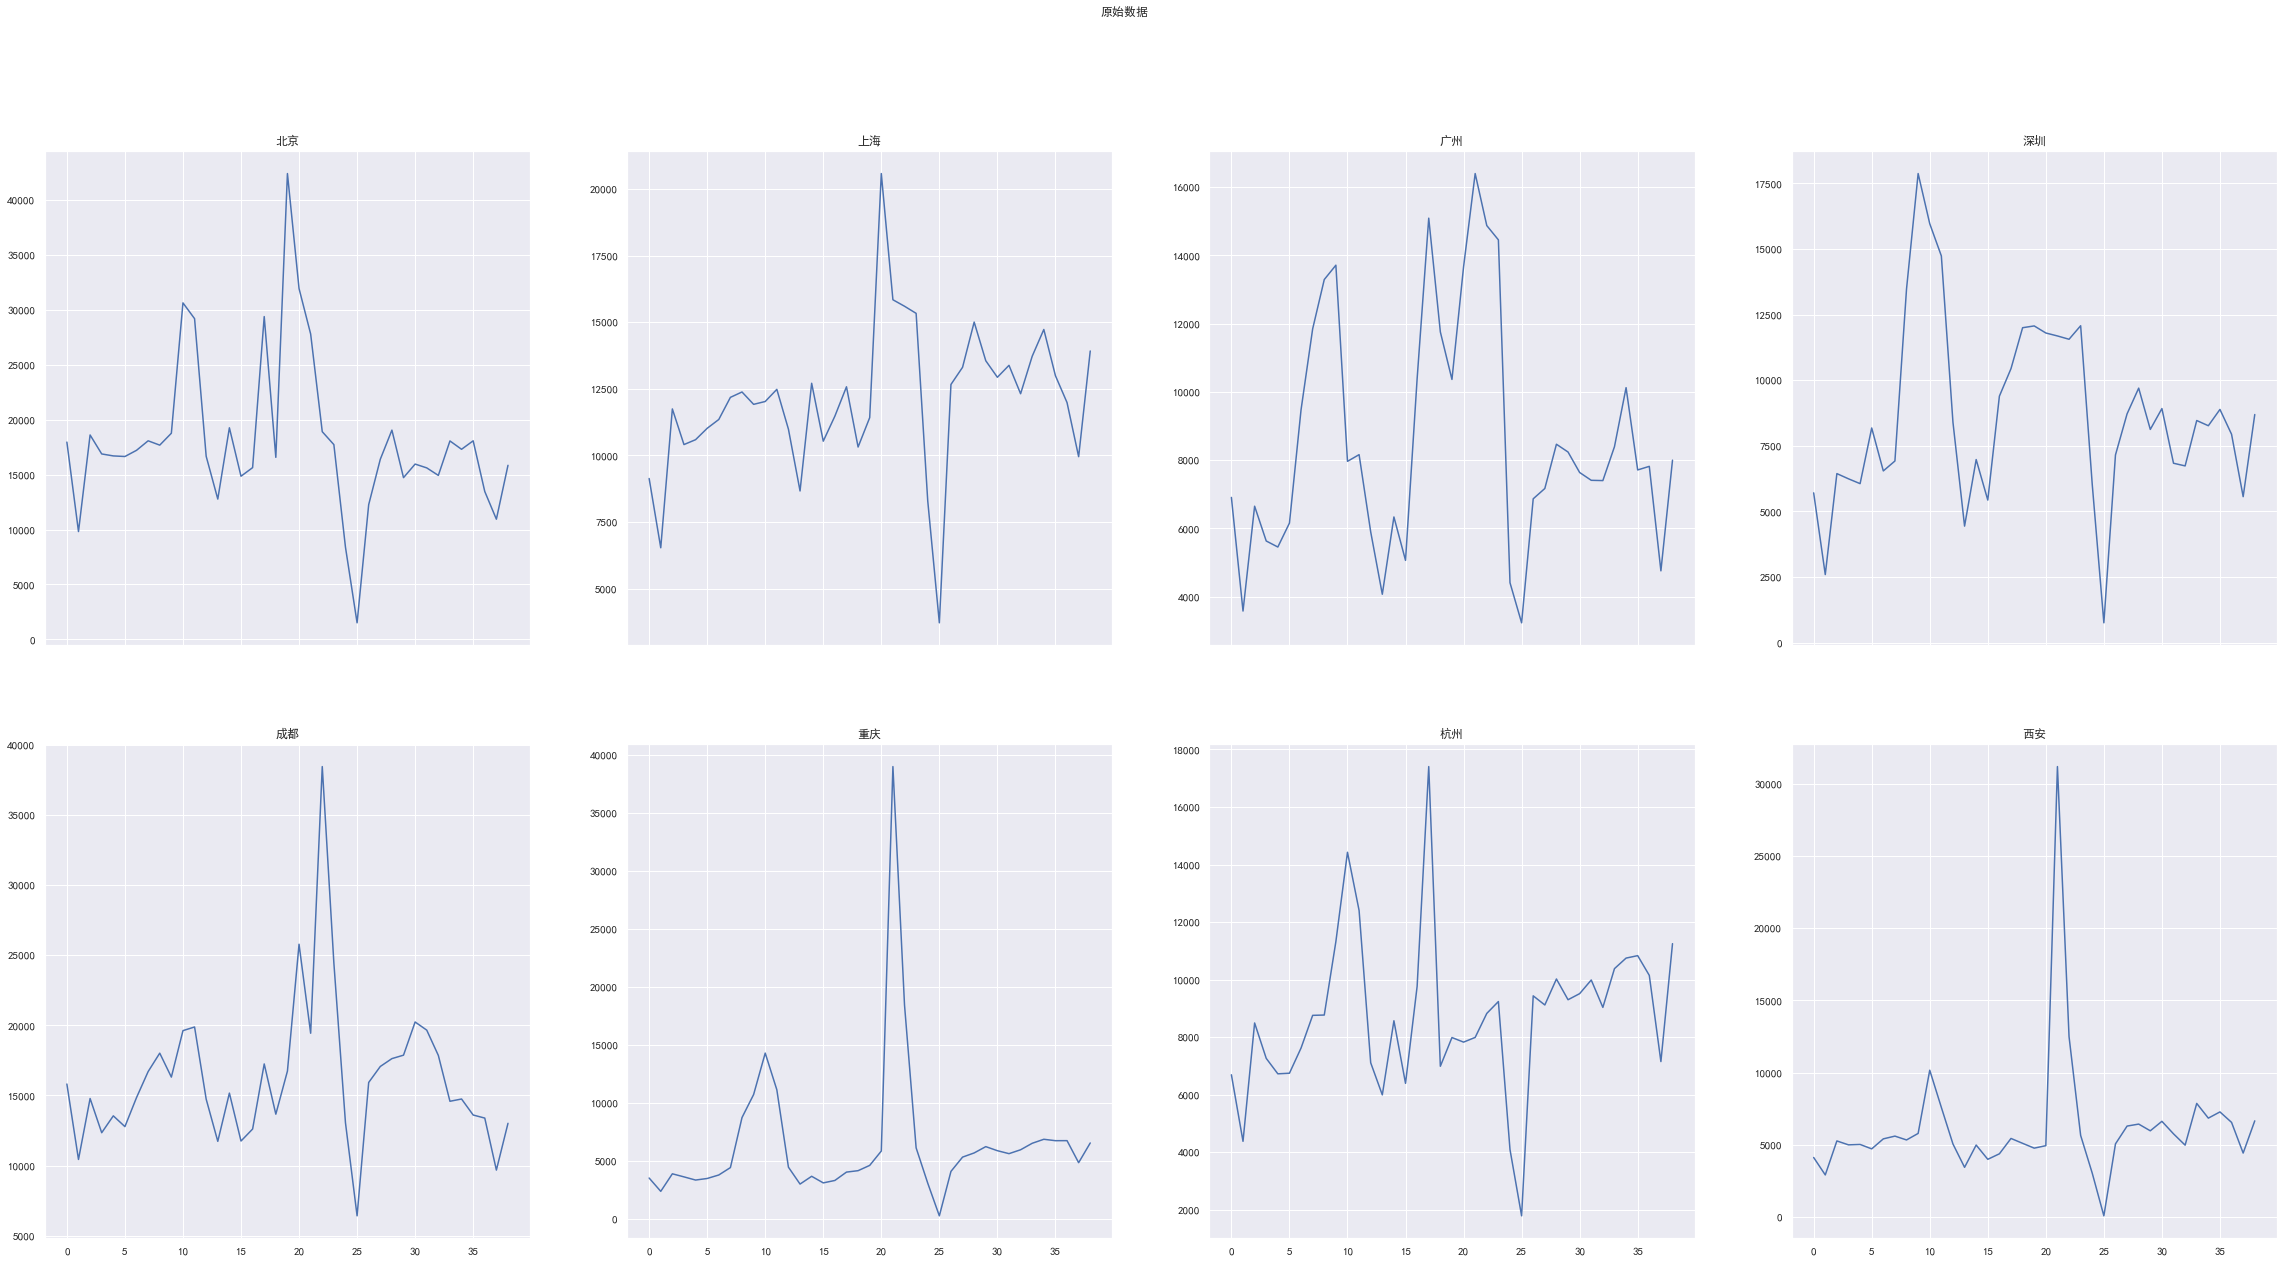

In [192]:
dGraph(2, 4, cityDF)

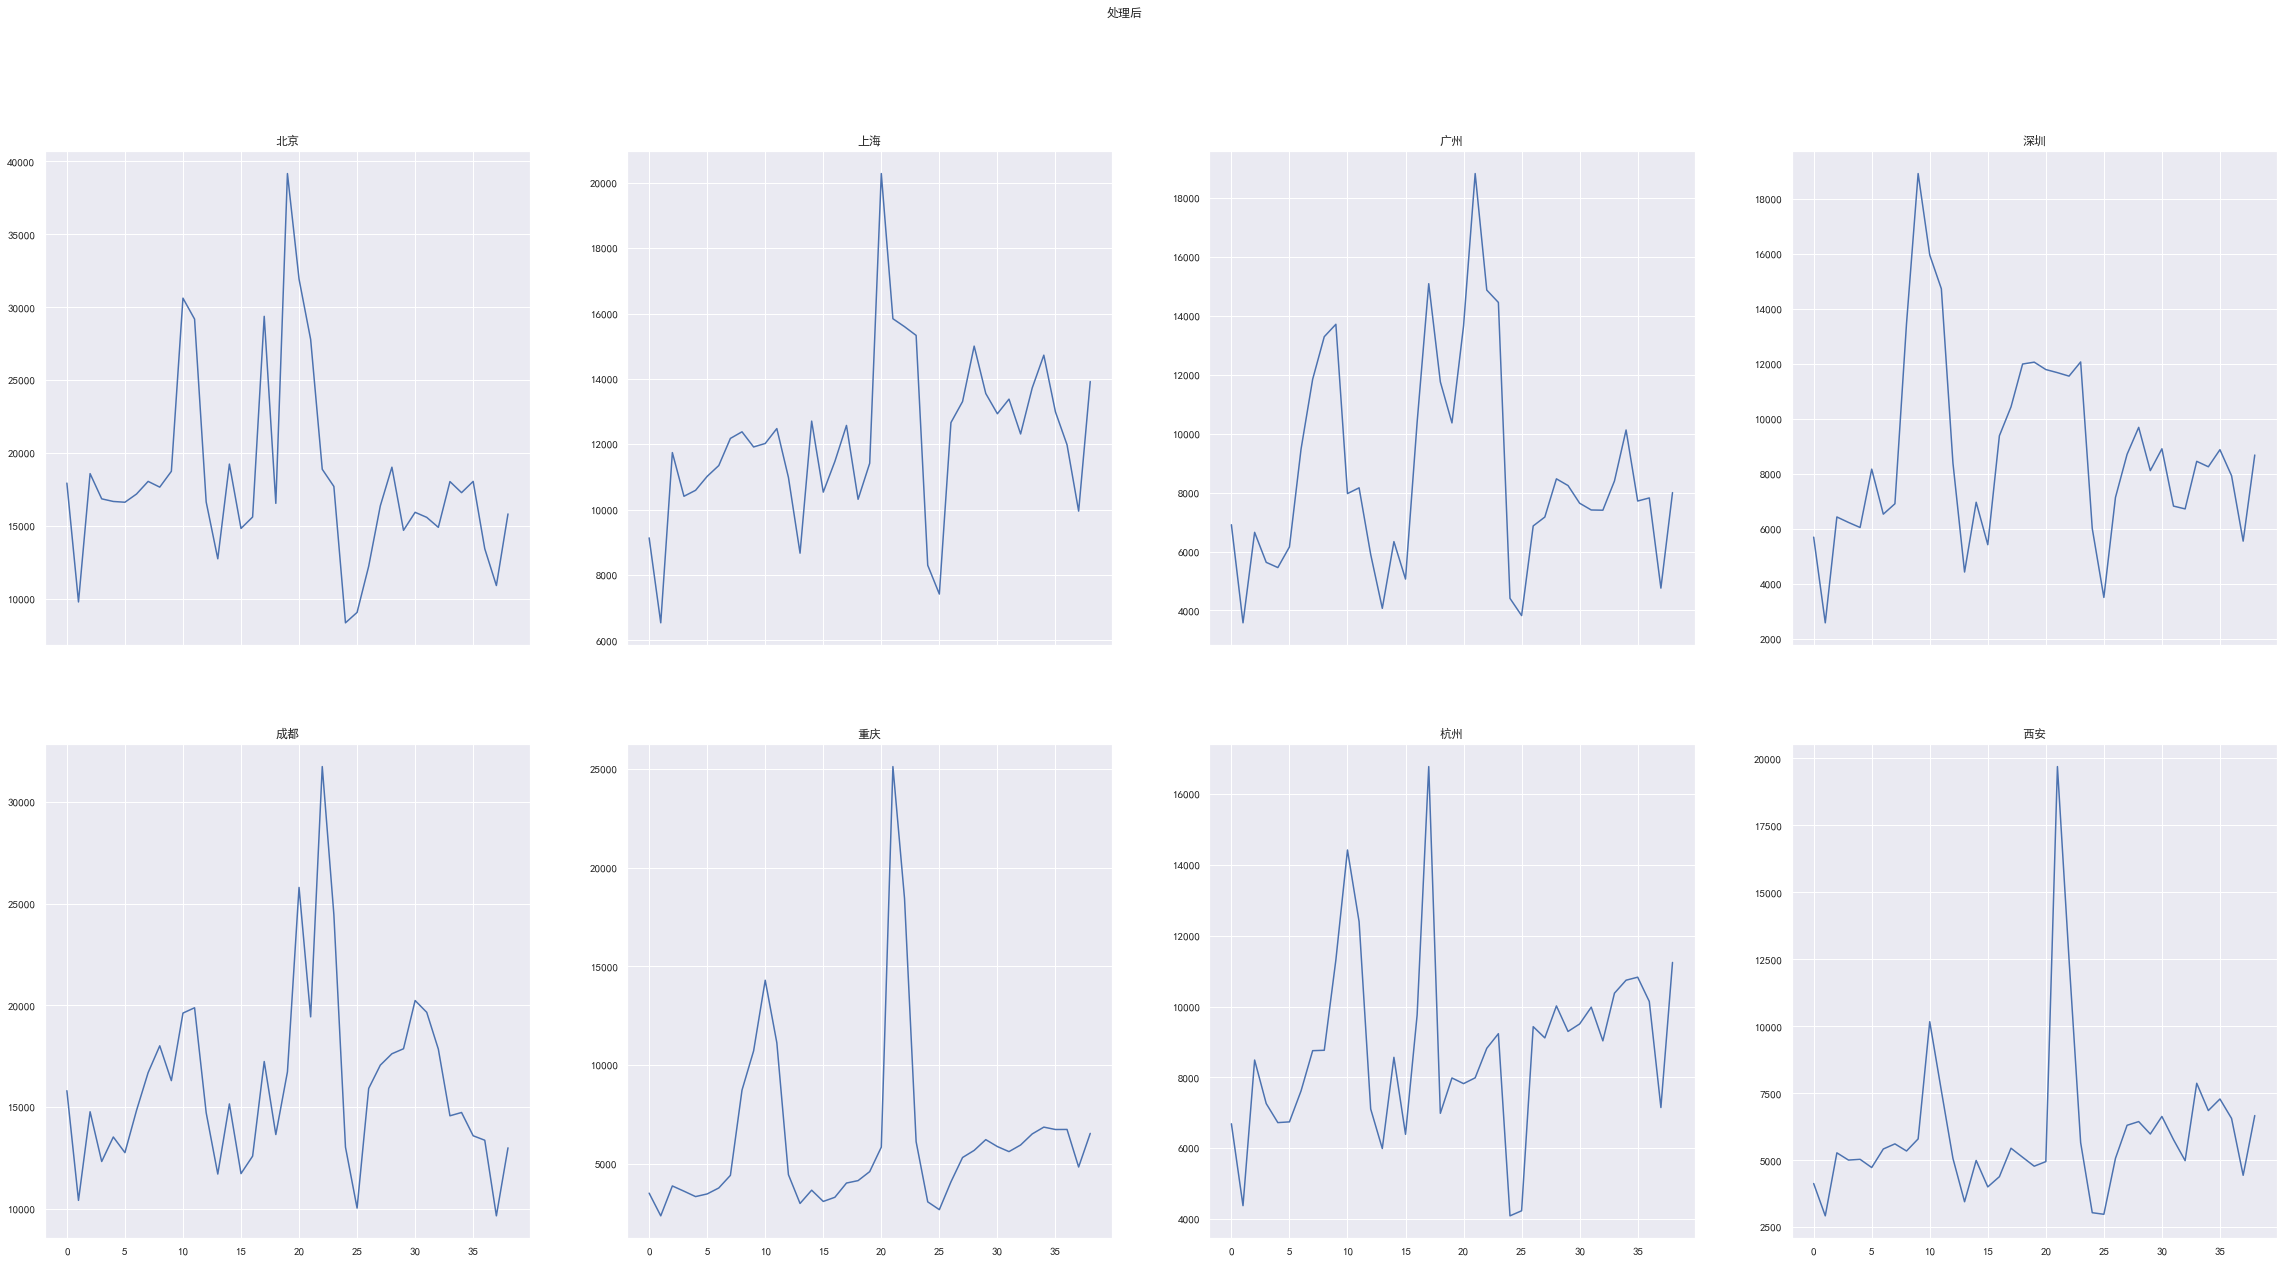

In [193]:
dGraph(2, 4, newdata(citys, True), True)

In [219]:
newCityDF = newdata(citys, True)
# 添加时间
# 这种方法可以，但是比较麻烦
# newCityDF.insert(0, '月份', df['月份'].drop_duplicates().values)
# 这种方法比较合适
# newCityDF.insert(0, '月份', pd.date_range(start="2018-01-01", periods=39, freq="M"))
# 由于R可以重新设置，所以不必添加月份，到R里再说
newCityDF.head()
# newCityDF['月份'] = df['月份'].drop_duplicates().values

,北京,上海,广州,深圳,成都,重庆,杭州,西安
0,17957,9137,6911,5707,15814,3518,6689,4134
1,9813,6538,3581,2592,10432,2370,4375,2928
2,18606,11747,6653,6441,14781,3883,8490,5280
3,16879,10410,5634,6242,12340,3618,7260,5009
4,16699,10593,5457,6058,13543,3344,6722,5037


In [220]:
newCityDF.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 8 columns):
北京    39 non-null int32
上海    39 non-null int32
广州    39 non-null int32
深圳    39 non-null int32
成都    39 non-null int32
重庆    39 non-null int32
杭州    39 non-null int32
西安    39 non-null int32
dtypes: int32(8)
memory usage: 1.3 KB


In [221]:
newCityDF.to_csv("%s/tsDataR.csv" % dataDir, index=False)

In [324]:
def mySplit(series, n_slpit=3):
    return [[series[:24], series[24: 29]], [series[:29], series[29:34]], [series[:34], series[34:]]]

In [360]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
def timeseriesCVscore(params, series, loss_function=mean_absolute_percentage_error, slen=12):
    """
        Returns error on CV  
        
        params - vector of parameters for optimization
        series - dataset with timeseries
        slen - season length for Holt-Winters model
    """
    # errors array
    errors = []
    
    values = series.values
    #print(series)
    alpha, beta, gamma = params
    
    # set the number of folds for cross-validation
    #tscv = TimeSeriesSplit(n_splits=3)
    # iterating over folds, train model on each, forecast and calculate error
    #for train, test in tscv.split(values):
    for train, test in mySplit(values):
        #print(train,len(test))
        #train = np.append(train, test[:-3])
        #test = test[-3:]
        
        # model = HoltWinters(series=values[train], slen=slen,
        model = HoltWinters(series=train, slen=slen,
                            alpha=alpha, beta=beta, gamma=gamma, n_preds=len(test))
        model.triple_expotential_smoothing()
        
        predictions = model.result[-len(test):]
        # actual = values[test]
        actual = test
        error = loss_function(predictions, actual)
        errors.append(error)
        
    return np.mean(np.array(errors))

In [385]:
data = newCityDF['西安']
# print(data)
x = [0.1, 0.1, 0.1]
opt = minimize(timeseriesCVscore, x0=x, 
               args=(data, mean_absolute_percentage_error), 
               method="TNC", bounds = ((0, 1), (0, 1), (0, 1),)
              )
alpha_final, beta_final, gamma_final = opt.x
print(opt)
print(alpha_final, beta_final, gamma_final)
model = HoltWinters(data, slen=12, alpha = alpha_final, 
                    beta = beta_final, 
                    gamma = gamma_final, 
                    n_preds = 3, scaling_factor = 1.96)
model.triple_expotential_smoothing()

     fun: 16.936684399524186
     jac: array([11.51511171,  0.        ,  2.48364067])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 6
     nit: 2
  status: 0
 success: True
       x: array([0.       , 0.0546687, 0.       ])
0.0 0.05466870495228171 0.0


In [386]:
model.result[-3:], list(data[-3:].values)

([6750.284722222226, 7023.194444444449, 7210.770833333338], [6564, 4441, 6671])

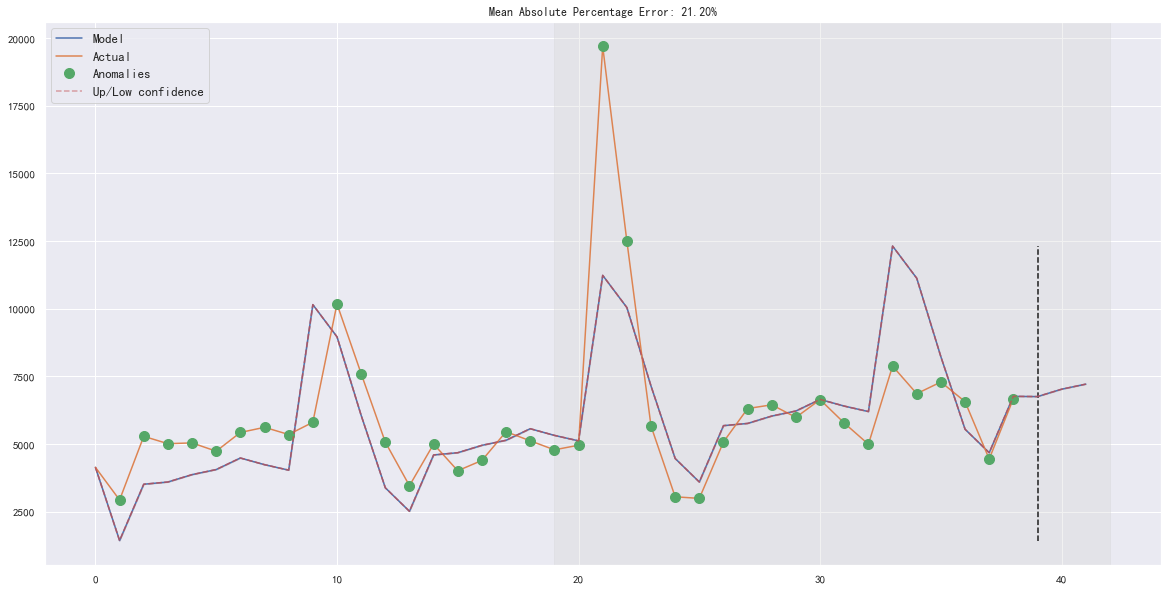

In [387]:
plotHoltWinters(data, plot_intervals=True, plot_anomalies=True)

In [164]:
testdf = df[(df['车型new']=='A4L')&(df['城市']=='上海')][['城市', '月份', '城市汇总']].reset_index(drop=True).copy()

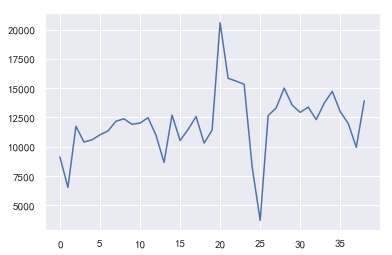

In [165]:
plt.plot(testdf['城市汇总'])

In [133]:
np.sqrt(np.var(testdf['城市汇总'])), np.max(testdf['城市汇总']), np.min(testdf['城市汇总']), np.mean(testdf['城市汇总'])

(5175.343360151432, 38464, 6409, 16193.23076923077)

In [44]:
testdf['城市汇总'].sort_values(axis=0, ascending=False)

22    38464
20    25789
23    24455
30    20240
11    19884
31    19660
10    19623
21    19438
8     18017
29    17873
32    17855
28    17627
17    17247
27    17067
19    16736
7     16702
9     16308
26    15926
0     15814
14    15166
6     14848
2     14781
34    14745
12    14735
33    14583
18    13663
35    13603
4     13543
36    13384
24    13046
38    13011
5     12775
16    12603
3     12340
15    11746
13    11724
1     10432
37     9674
25     6409
Name: 城市汇总, dtype: int32

In [11]:
def avgPeak(maxidx, minidx, varvalue):
    # 因为2019年9月值过大，所以需要将其减少到合理的范畴，否则会影响后续的趋势
    # 同时，2020年2月因ncov的问题，导致数据过低，同样影响后续趋势
    # 直接使用周期内的平均值(12个月前 + 12个月后)/2
    #return int(testdf.loc[[maxidx-12, maxidx+12], '城市汇总'].mean()), int(testdf.loc[[minidx-12, minidx+12], '城市汇总'].mean())
    # 改成如果需要处理，那么就是最大值是次大值+2var
    return False

In [12]:
newmax, newmin = avgPeak(np.argmax(testdf['城市汇总']), np.argmin(testdf['城市汇总']))

/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmax' is deprecated, use 'idxmax'
instead.
The behavior of 'argmax' will be corrected to return the positional
maximum in the future. For now, use 'series.values.argmax' or
'np.argmax(np.array(values))' to get the position of the maximum
row.
  return getattr(obj, method)(*args, **kwds)
/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:51: FutureWarning: 
The current behaviour of 'Series.argmin' is deprecated, use 'idxmin'
instead.
The behavior of 'argmin' will be corrected to return the positional
minimum in the future. For now, use 'series.values.argmin' or
'np.argmin(np.array(values))' to get the position of the minimum
row.
  return getattr(obj, method)(*args, **kwds)


In [13]:
testdf.loc[np.argmax(testdf['城市汇总']), '城市汇总'] = newmax
testdf.loc[np.argmin(testdf['城市汇总']), '城市汇总'] = newmin

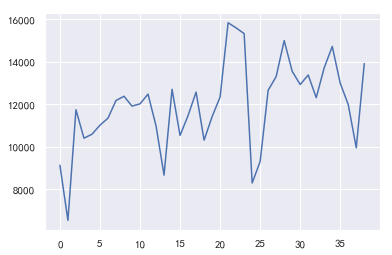

In [14]:
plt.plot(testdf['城市汇总'])

In [15]:
# maxv = testdf.loc[20, '城市汇总']
# testdf.loc[20, '城市汇总'] = int(maxv*0.8)
# minv = testdf.loc[25, '城市汇总']
# testdf.loc[25, '城市汇总'] = int(minv*1.6)

In [17]:
#model = HoltWinters()